[View in Colaboratory](https://colab.research.google.com/github/ryanlakritz/dataviz/blob/master/t_SNE_Visualization_Tutorial.ipynb)

#t-SNE Tensor Visualization Tutorial

## **Getting Started:**
1. Use Google Chrome

2. Run first two chunks using the [*Play Button*] on the top left corner of each chunk
    1. The first chunk imports a number of packages for data manipulation and visualization
    2.  The function *configure_plotly_browser_state()* allows plotly to show in the notebook
    
3. Enable 3rd party cookies (also necessary for plotly to show in the notebook). Don't worry, you can block them again afterwards.
    1. settings
    2. search "cookies"
    3. content settings
    4. cookies
    5. Uncheck "Block third-party cookies"

4. Click [+] CODE (above) to add a new chunk of code after  *configure_plotly_browser_state()*

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot

# lets numpy print longer lines for displaying matrices
np.set_printoptions(linewidth=1000)

In [0]:
# setup plotly function to work in colab (make sure to enable 3rd party cookies)
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
init_notebook_mode(connected=False)

The following code reads in a dataset that is publicly hosted on *pjreddie.com*. The first line reads the csv with the pandas function *read_csv()*, specifying that no header exists in the dataset, and saves it as the variable **df**. The second line displays the "head", first n-rows of data. Now we can see what the data we're working with looks like.

In [0]:
data = pd.read_csv("https://pjreddie.com/media/files/mnist_train.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that the dataset has 785 columns: 
>The value of each row is defined by the first column, column 0. For example, the first row represents a '5'.

>The remaining columns (1 - 784) each define a single pixel of a drawing of that row's value. For example, columns 1-784 represent all the pixels of a drawing of a '5'. 

One thing that we also see in this dataset and have to clean up are the column names. They're currently stored as numeric column names, which can work, but it's easier to work with column names that are strings.

To do this, first create a new empty array variable called *col_names*. The next line uses a **for-loop** to paste together the string "pixel_" with the number of the column. Next, rename the first entry in that array (element 0 because python is 0-indexed) to 'value'. *print()* will display the array you now have. Finally, define the dataframes column names to *col_names*.

In [0]:
col_names = []
col_names = ['pixel_'+str(col) for col in data.columns]
col_names[0] = 'value'

print(col_names)

data.columns = col_names
data.head()

This sets up the two main dataframes that we'll be working with for this project: **train** and **pixel**. **train** is a random sample of 5000 entries from the dataframe -- we need to reset the index so that the entries have a new index from 0-4999. **pixel** is mostly the same as **train**, but without the *value* column. It additionally specifies that we only want the *.values*, a clean array for each row of data. Defining this new dataframe will make a few things later easier.

One thing that happens in the first line is called method-chaining. This is when multiple functions (methods) are applied in sequential order. First we get random sample of df, and then reset the index of the resulting dataframe.

In [0]:
df = data.sample(n=5000).reset_index(drop=True)

pixels = df.drop('value', axis=1).values

Let's take a look at how this dataframe actually represents a number. The 784 pixels are really a 28X28 matrix. Each value represents the intensity of that pixel. We can reshape and display the first row to look like a 28X28 matrix.
1. *[0]* filters down to just the first row of the dataframe
2. reshape it as a 28X28 matrix

In [0]:
first_val = pixels[0].reshape((28,28))
print(first_val)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  86 253 255 253 198  85  86  85   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  85 251 253 251 253 251 253 251 169  56   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  85 253 254 253 254 253 254 253 254 253 254  84   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  28 196 253 251 253 251 253 251 253 251 253 19

Using matplotlib, we can also visualize it on a graph.

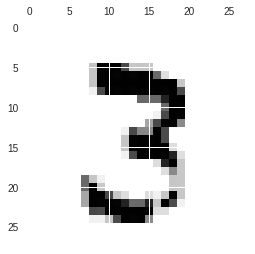

In [0]:
plt.matshow(first_val)

Let's plot some more.

First, we define a new matplotlib *figure* as *fig* and give it a size. Then we set up a for loop to plot the first ten numbers. For each loop, add a new subplot and specify its position in the figure. Finally, plot each entry onto the figure -- this uses similar syntax to *first_val*, but replaces 'loc[0]' with 'loc[i]'.

In [0]:
# plot more entries
fig = plt.figure(figsize=(16,7))
for i in range(10):
    subplot = fig.add_subplot(2,5,i+1) # specifies 2X5 subplot with position i+1
    subplot.matshow(pixels[i].reshape((28,28)))


Now for t-SNE:

The **scikit-learn** package makes the syntax incredibly easy to set up. First define a new model, specifying a few argument. You could theoretically just set *n_components*, but the others make the model fit better for this dataset.

Fit the model on **pixels**. Because we set *verbose=1*, it will show a few of the steps that it's going through while fitting. *Mean sigma, KL divergence, and Error after n iterations*  are all checks of measurements that the model is evaluating itself on.

This may take a couple minutes

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=700)
tsne_results = tsne.fit_transform(pixels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.238s...
[t-SNE] Computed neighbors for 5000 samples in 33.921s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 492.073737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.377739
[t-SNE] Error after 700 iterations: 1.531116


Save the results as two new columns in **df**

In [0]:
df['x-tsne'] = tsne_results[:,0]
df['y-tsne'] = tsne_results[:,1]

Create a custom color palette for t-sne plots, using colors from color brewer. 
1. Go to colorbrewer2.org and select a qualitative color scheme with 10 data classes. This link has one all set: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=10
2. Click 'Export'
3. Copy the JavaScript array (same as Python) and create a new array called *colors*


Now, you have to map those colors to the each of the distinct values in the dataset (0-9). Each value will get its own distinct color. *map()* allows you to map a function to a set of values. we will essentially be mapping the color palette to the values in the dataset. The way to do this is using **lambda x**. **lambda x:** says that you want to apply the same function to each line of the series -- this one specifies that each 'value' gets that index of *colors*.
>e.g. value=0 maps to '#a6cee3'; value=3 maps to '#33a02c'


In [0]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']


color_map = map(lambda x: colors[x], df['value'])
df['color'] = list(color_map)

Make a scatterplot using matplotlib. You'll be setting *x, y, c (color), and alpha*

In [0]:
fig = plt.subplots(figsize=(10,6))
plt.scatter(x=df['x-tsne'], y=df['y-tsne'], c=df['color'], alpha=0.5)

Now to create a 3-D t-SNE model and visualization. It uses largely the same modeling, except that *n_components=3*.

In [0]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=700)
tsne_results = tsne.fit_transform(pixels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.237s...
[t-SNE] Computed neighbors for 5000 samples in 34.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 492.073737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.481133
[t-SNE] Error after 700 iterations: 1.319182


In [0]:
df['x-tsne'] = tsne_results[:,0]
df['y-tsne'] = tsne_results[:,1]
df['z-tsne'] = tsne_results[:,2]

Now plotting with the plotly package. Plotly is great for quick interactive plots, with fairly straightforward syntax.

Make sure to call *configure_plotly_browser_state()* if doing this in Google Colab -- it is necessary for it to render in the web browser.

Then create a new plotly 3-D scatter object called *scatter*. Define *x,y, and z* to establish the positions on the graph. Set *mode='text'* for the scatter plot, so that we can plot the numbers themselves instead of just dots on the chart. Then define *text* as the values, and *textfont* (this has to be a dictionary as it can take in multiple arguments for the font). The scatter object has to be wrapped in **[ ]** because it must be an array.

Create a figure object called *fig* and finally call iplot on the figure.

In [0]:
# plot in plotly
configure_plotly_browser_state()

scatter = [go.Scatter3d(
    x=df['x-tsne'],
    y=df['y-tsne'],
    z=df['z-tsne'],
    mode='text',
    text=df['value'],
    textfont=dict(
        color=df['color']
    )
)]

fig = go.Figure(data=scatter)

iplot(fig)
